<a href="https://colab.research.google.com/github/ruvxn/Traffic-Based-Route-Guidance-System/blob/main/Traffic_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparing the data

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving traffic_cleaned.csv to traffic_cleaned.csv


In [ ]:
df = pd.read_csv('/content/traffic_cleaned.csv')
df['DateTime'] = pd.to_datetime(df['DateTime'])
df = df.sort_values(['SCATS Number', 'DateTime'])
df.head()


,SCATS Number,Location,Date,Interval,Volume,Time,DateTime
0,2200,UNION_RD N of MAROONDAH_HWY,2006-10-01,V00,25,00:00,2006-10-01 00:00:00
31,2200,MAROONDAH_HWY E of UNION_RD,2006-10-01,V00,38,00:00,2006-10-01 00:00:00
62,2200,UNION_RD S of MAROONDAH_HWY,2006-10-01,V00,36,00:00,2006-10-01 00:00:00
93,2200,MAROONDAH_HWY W of UNION_RD,2006-10-01,V00,47,00:00,2006-10-01 00:00:00
2883,2200,UNION_RD N of MAROONDAH_HWY,2006-10-01,V01,17,00:15,2006-10-01 00:15:00


In [ ]:
window = 4
forecast = 1

In [ ]:
x_all, y_all = [],[]

for site, group in df.groupby('SCATS Number'):
    #print(f'sitenumber: {site}')
    volumes = group['Volume'].values
    #print(volumes)


    for i in range(len(volumes) - window - forecast+1):
        x_all.append(volumes[i:i+window])
        y_all.append(volumes[i+window+forecast-1])


X = np.array(x_all)
y = np.array(y_all)


In [ ]:
X.shape

(276664, 4)

In [ ]:
y.shape

(276664,)

In [ ]:
y_prescale = y.reshape(-1,1)
y_prescale.shape

(276664, 1)

In [ ]:
Scaler = MinMaxScaler()

X_scaled = Scaler.fit_transform(X)
y_scaled = Scaler.fit_transform(y_prescale)

In [ ]:
X_scaled = X_scaled.reshape((X_scaled.shape[0], window, 1))


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, shuffle=False
)


# Training the model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

In [ ]:
model = Sequential()
model.add(LSTM(64,activation='tanh',input_shape=(window, 1),kernel_regularizer=regularizers.l2(0.01)))  # L2 regularization
model.add(Dropout(0.2))
model.add(Dense(1, kernel_regularizer=regularizers.l2(0.01)))  # L2 on Dense

model.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.summary()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=20,
                    batch_size=64,
                    callbacks=[early_stop],
                    verbose=1)

Epoch 1/20
3459/3459 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - loss: 0.0121 - val_loss: 0.0032
Epoch 2/20
3459/3459 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - loss: 0.0061 - val_loss: 0.0033
Epoch 3/20
3459/3459 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 0.0058 - val_loss: 0.0037
Epoch 4/20
3459/3459 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.0057 - val_loss: 0.0035


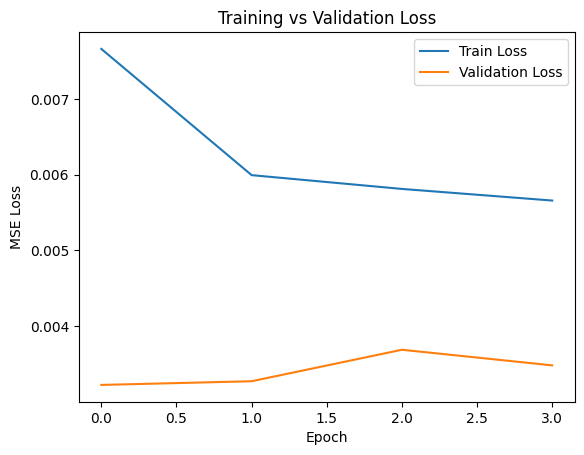

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

In [ ]:
y_pred = model.predict(X_test)


1730/1730 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


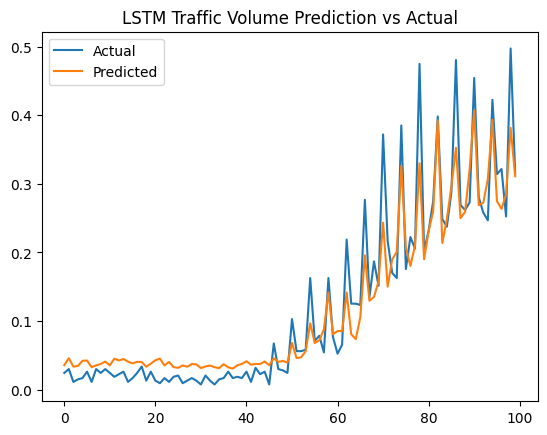

In [ ]:
plt.plot(y_test[:100], label='Actual')
plt.plot(y_pred[:100], label='Predicted')
plt.legend()
plt.title('LSTM Traffic Volume Prediction vs Actual')
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score

print("MAE:", mean_absolute_error(y_test, y_pred)) # aim for close to 0
print("R^2:", r2_score(y_test, y_pred)) # aim for close to 1

MAE: 0.03772453875591144
R^2: 0.8433674866732546


In [ ]:
model.save("lstm_model.h5")

In [ ]:
from google.colab import files
files.download("lstm_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>